# Second model for Graph Partitioning in Connected Components

## Problem statement

Let 
* $G = (V,E)$ be an undirected graph, with $V = \{1,\ldots, n\}$ being its node set, and $E \subset \{ \{i,j\}:\, i,j\in V, i \neq j \}$ being its edge set. 
* $ d: E \to \mathbb{R}^{+}$ be a cost function, 
* $k\geq 2$ an integer denoting the fixed number of connected components to partition $G$ into,
* $\alpha \geq 2$ an integer numbers representing the minimum cardinality of each connected component.

A $k$-partition of $V$ is a set $\{V_1,V_2,\ldots,V_k\}$ where $V_i\cap V_j=\emptyset$ for all $i\neq j$, $\bigcup_{c=1}^k V_c=V$, and $V_c \neq \emptyset$ for all $ c \in [k]$, where $[k]$ denotes the set $\{1,\ldots,k\}$. 


The partitioning problem in connected components with minimum size constraints consists of finding a  $k$-partition $\{V_1,V_2,\ldots,V_k\}$ such that each subset $V_c$ induces a connected subgraph, with $|V_c| \geq \alpha$, and the total cost of the edges with end nodes in the same subset of the partition is minimized.


Observe that each connected component of $G$ will have at most $\beta := n-(k-1)\alpha$ nodes. Moreover,  $\alpha$ has to be less than $ \left\lceil \frac{n}{k} \right\rceil$, otherwise the problem is infeasible.

Let us consider the $k$-augmenting graph of $G$, which is the pair $G^k=(V^k, E^k)$, where $V^k=V\cup \mathbb{A}$, $\mathbb{A}=\{n+1,n+2, \ldots, n+k\}$ is a set of artificial nodes (one for each connected component in the partition), $E^k=E\cup E_1$,  and $E_1= \{ \{i,j\}: i \in V, j \in \mathbb{A}\}$.  For each edge $\{i,j\}\in E$, the original cost $d_{ij}$ is retained, while the edges in $E_1$ have a cost set equal to $0$. 

* $y_i^c$ is a binary variable taking the value of one if the node $i \in V$ belongs to $V_c$, for some $c \in [k]$, and zero otherwise;
* $x_{ij}$ takes the value of one if the edge $\{i,j\} \in E$ belongs to any connected component, and zero otherwise;
* $f_{i,j}$ is a continuous variable representing the flow over the arc $(i,j)$. 

Here each edge $\{i,j\}$ has two associated antiparallel arcs, namely $(i,j)$ and $(j,i)$. Also, sets $\delta_j^−$ and $\delta_j^+$ contain ingoing and outgoing arcs to the node $j$, respectively. 

\begin{align}
\min &\sum_{\{i,j\} \in E} d_{ij}\, x_{ij}
\\
\text{s.t.}\qquad & 
\\
&\sum_{c\in [k]} y_i^{c} = 1 &&\forall i \in V,
\\
&y_i^{c}+y_j^{c}-x_{ij} \leq 1    &&\forall \{i,j\}\in E, c \in [k],
\\
&y_i^{c}+y_j^{\ell}+x_{ij} \leq 2       &&\forall \{i,j\}\in E, c,\ell \in [k], c\neq \ell,
\\
&\sum_{j \in V} x_{ij} = 1                  &&\forall i \in \mathbb{A},
\\
&\sum_{j \in V} f_{ij} = \sum_{j\in V} y_j^c                  &&\forall i \in \mathbb{A}, c\in [k],
\\
\\
&\sum_{(i,j) \in \delta_j^-} f_{ij} - \sum_{(j,i) \in \delta_j^+} f_{j,i}
= 1
&&\forall j \in V,
\\
&f_{ij} + f_{ji} \leq \beta x_{ij}                          &&\forall \{i,j\}\in E,
\\
&\alpha x_{ij} \leq f_{ij} \leq \beta x_{ij},               &&\forall i \in \mathbb{A}, j \in V.
\end{align}

## Implementation

In [1]:
from   gurobipy   import *
import pandas as pd    # https://pandas.pydata.org/
import numpy  as np    # Numpy
import igraph as ig    # 
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
#from InstancesGenerator import Graph_Instance      # Not needed
from warnings     import warn
from os           import listdir
from re           import findall

from collections  import deque, Counter
from itertools    import chain 
from numpy.random import default_rng
from matplotlib   import cm

from numpy import floor

An instance is selected. For more information about the available instances, see [```Instance generator NB.ipynb```](Instance%20generator%20NB.ipynb) and the associated function [```InstancesGenerator.py```](InstancesGenerator.py).

In [3]:
ins = 'Tailed_Tree'

In [4]:
Instance_path = 'Instances/'
instance = [f[:-4] for f in listdir(Instance_path) if f.startswith(ins)][0]
k, α = [int(i) for i in findall(r'\((.*?)\)',instance)[-1].split(',')]
display(instance)

'Tailed_Tree,(4,9)'

In [5]:
file   = 'Instances/{0},({1},{2}).pkl'.format(ins,k,α)

In [6]:
'''rng = default_rng(0)
#G = Graph_Instance('IEG(45)')
G = ig.Graph.Tree(33,3) #ig.Graph.Tree(30,1) (2,2) works nice
tailₐ = 20
G.add_vertices(2*tailₐ)
G.add_edges([(i,i+1) for i in range(32,32+tailₐ)])
G.add_edges([(30,32+tailₐ+1)] + [(i,i+1) for i in range(32+tailₐ+1,32+2*tailₐ)])
G.es['w'] = rng.integers(1, 10, G.ecount(), endpoint=True)
G.to_undirected()
G = G.simplify(combine_edges='min')'''
G = ig.Graph.Read_Pickle(file)

In [7]:
A = G.get_edgelist() # edges
V = G.vs.indices     # nodes
n = G.vcount()
m = G.ecount()

print('(n,m) =', (n,m),'\nCost:',sum(G.es['w']))

(n,m) = (73, 72) 
Cost: 408


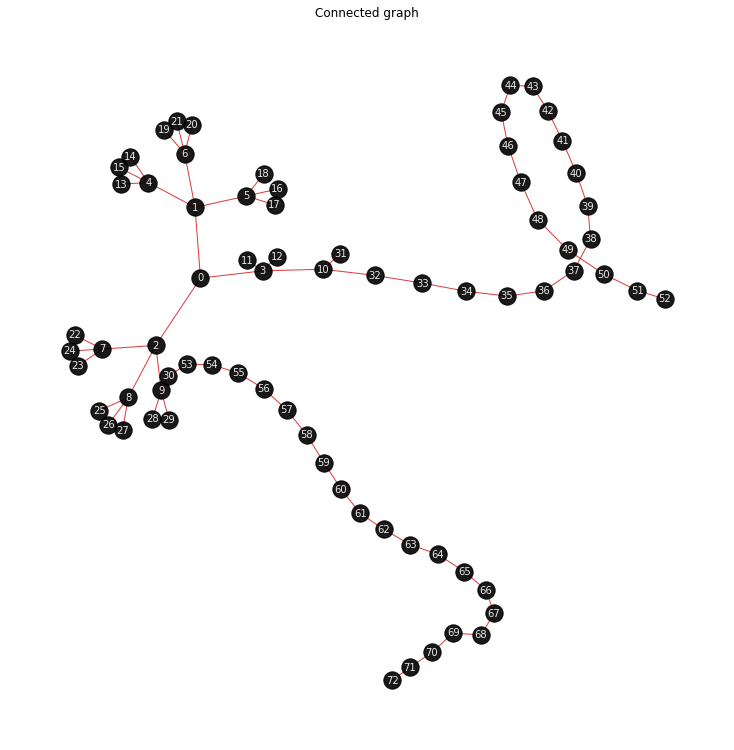

In [8]:
# Display graph
plt.figure(figsize=(10,10))
nx.draw(G.to_networkx(), nx.spring_layout(G.to_networkx(), seed=1), with_labels=True, 
        width=1, alpha=0.9, edge_color="tab:red",font_size=10, font_color="white",node_color="black")
plt.title('Connected graph' if G.is_connected() else 'Warning: unconnected graph')
plt.draw()

In [9]:
'''
k = 4;     K = tuplelist(range(k))    # Number of connected components
α = 9                                 # Minimum number of nodes per component
'''
K = tuplelist(range(k))               # Index of connected components
β = n - (k-1)*α                       # Maximum number of nodes per component
print('Created instance with (k,α,β) = ({0},{1},{2}).'.format(
    k,α,β)) if α <= floor(n/k) else warn('\n\n*** α is too big! ***\n\n')

Created instance with (k,α,β) = (4,9,46).


In [10]:
𝔸ᵏ = [n+i for i in K]
Vᵏ = V + 𝔸ᵏ
Eᵏ = [(i,j) for i in 𝔸ᵏ for j in V]

In [11]:
d = {a:G.es[G.get_eid(a[0],a[1])]['w'] for a in G.get_edgelist()}    # cost function
d.update({e: 0.0 for e in Eᵏ})

Eₒ = sorted(set(A))
E  = sorted( set(A).union(set(Eᵏ)) )                                  # Augmented graph
Aᶜ = G.complementer(loops=False).get_edgelist()
Eᶜ = sorted(set(Aᶜ))                                                 # Edges not in original graph
TE = E+[(j,i) for (i,j) in sorted(set(A))]                           # All edges from complete graph

In [12]:
# To improve numerics, we will divide the objective by
D = 1.0#/(2*k) #
D = 0.5 * sum(G.es['w']) / k

### Create model

In [13]:
if 'mo' in globals():        mo.dispose();    disposeDefaultEnv();    del mo

In [14]:
mo = Model()
x, x̄, y, f = tupledict(), tupledict(), tupledict(), tupledict()    # Dictionaries will contain variables

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-10-17


In [15]:
# *** Variables ***
# Link inside connected component #|x| = m + n*k
x = mo.addVars(E, vtype = 'B', name = 'x')
deque( (x[i,j].setAttr('obj', d[i,j]/D) for (i,j) in E), maxlen=0);    # Objective costs

# Indicator of connected component #|y| = n * k
y = mo.addVars(V, K, vtype = 'B', name = 'y')

# Flow on induced graph #|f| = 2*m + n*k
f = mo.addVars(TE, vtype = 'C', name = 'f')

In [16]:
mo.update()

In [17]:
# *** Constraints ***
# Each node must belong exactly to one cluster
mo.addConstrs((quicksum(y[i,c] for c in K) == 1 for i in V), name = 'R-2b-');
# If two nodes i,j ∈ V are assigned to Vₖ, then the edge {i,j} ∈ E belongs to the induced subgraph (Vₖ,E(Vₖ))
mo.addConstrs((y[i,c]+y[j,c]-x[i,j] <= 1.0  for (i,j) in Eₒ for c in K), name = 'R-2c-');
# Edges with end nodes in different connected components must be equal to zero
mo.addConstrs((y[i,c]+y[j,l]+x[i,j] <= 2.0 for (i,j) in Eₒ for c in K for l in K if c!=l), name = 'R-2d-');
# Only one artificial edge is active
mo.addConstrs((quicksum(x[i,j] for j in V) == 1.0 for i in 𝔸ᵏ), name = 'R-2e-');
# Flow will be sent through the active xᵢⱼ
mo.addConstrs((quicksum(f[i,j] - y[j,i-n] for j in V) == 0.0 for i in 𝔸ᵏ), name = 'R-2f-');
# Flow conservation
'''In_V  = {i:[(j,i) for j in G.neighbors(i)]+[(j,i) for j in Aᵏ] for i in V}
Out_V = {i:[(i,j) for j in G.neighbors(i)] for i in V}
mo.addConstrs((quicksum(f[i,j] for (i,j) in In_V[j]) - 
               quicksum(f[j,i] for (j,i) in Out_V[j]) == 1.0  for j in V), name = 'R-2i-g-');'''
FC = mo.addConstrs((quicksum(f[i,j] - f[j,i] for i in G.neighbors(j)) + 
                    quicksum(f[i,j] for i in Aᵏ) == 1.0  for j in V), name = 'R-2i-g-');

# Capacities for the antiparallel arcs associated to edge {i,j} ∈ E
mo.addConstrs((f[i,j] + f[j,i] <= β*x[i,j] for (i,j) in Eₒ), name = 'R-2h-');
# Min and max flow
mo.addConstrs((α * x[i,j] <= f[i,j] for (i,j) in Eᵏ), name = 'R-2i-a-');
mo.addConstrs((β * x[i,j] >= f[i,j] for (i,j) in Eᵏ), name = 'R-2i-b-');

In [18]:
# Lazy constraints for flow conservation 
#for a in FC.keys():    FC[a].Lazy = 1

### Optimization

In [19]:
mo.Params.TimeLimit = 8*60
mo.optimize()

Set parameter TimeLimit to value 480
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1962 rows, 1092 columns and 6588 nonzeros
Model fingerprint: 0x7a02d403
Variable types: 436 continuous, 656 integer (656 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 374 rows and 110 columns
Presolve time: 0.04s
Presolved: 1588 rows, 982 columns, 5340 nonzeros
Variable types: 436 continuous, 546 integer (546 binary)

Root relaxation: objective 2.784314e+00, 609 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.78431    0   51          -    2.78431      -     -    0s
     0     0    4.37692    0  1

In [20]:
Vₖ = {c:[i for i in V if y[i,c].x>0.0] for c in K}
print(Vₖ)

{0: [0, 2, 3, 7, 8, 9, 11, 12, 22, 23, 24, 25, 26, 27, 28, 29, 30, 53, 54, 55], 1: [10, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], 2: [1, 4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21], 3: [56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]}


In [21]:
[G.induced_subgraph(Vₖ[c]).is_connected() for c in K]

[True, True, True, True]

In [22]:
{D*sum(x[i,j].obj for (i,j) in E if x[i,j].x > 0.0)}

{379.99999999999994}

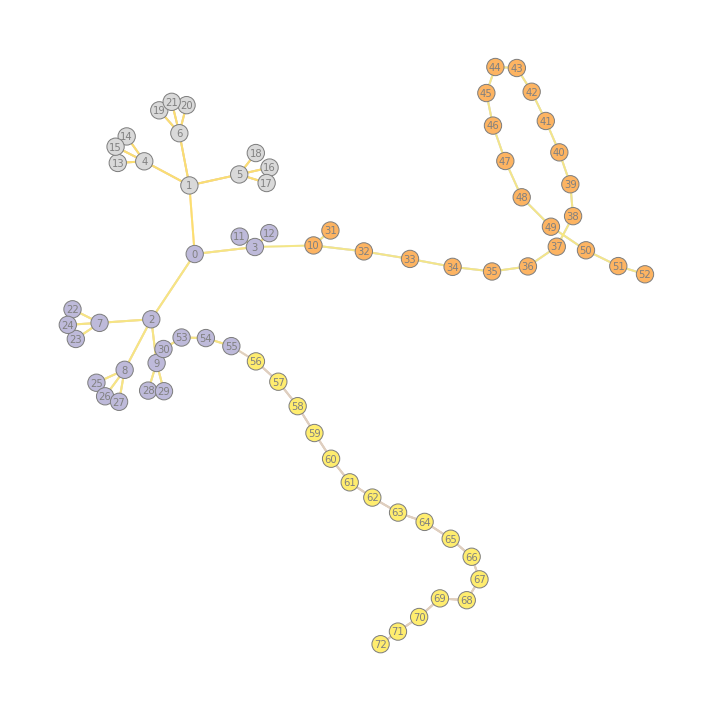

In [23]:
# Display graph with partitions
pos = nx.spring_layout(G.to_networkx(), seed=1)  # positions for all nodes
Col = cm.Set3(np.linspace(0.2, 1, k))

plt.figure(figsize=(10,10))
# Nodes
options = {"edgecolors": "tab:gray"}#, "node_size": 800, "alpha": 0.9}
for c in K:
    nx.draw_networkx_nodes(G.to_networkx(), pos, nodelist=Vₖ[c], node_color=[Col[c] for i in Vₖ[c]], **options)

# Edges
nx.draw_networkx_edges(G.to_networkx(), pos, width=0.5, alpha=0.5)
for c in K:
    Eₖ = [e.tuple for e in G.es if e.tuple[0] not in Vₖ[c] and e.tuple[1] not in Vₖ[c]]
    nx.draw_networkx_edges(
        G.to_networkx(), pos, edgelist=Eₖ,
        width=2, alpha=0.75,
        edge_color=[Col[c] for e in Eₖ],
    )

'''nx.draw(G.to_networkx(), pos, with_labels=True, 
        width=1, alpha=0.9, edge_color="tab:red",font_size=10, font_color="white",node_color="black")'''
nx.draw_networkx_labels(G, pos, {i:i for i in G.vs.indices}, font_size=10, font_color="gray")

plt.tight_layout()
plt.axis("off")
plt.draw()

In [24]:
Data = pd.DataFrame.from_dict(
    {'Instance':[(n,m,k,α)],
     'z_R':[mo.ObjBound * D],'Obj': mo.objval * D,'gap': mo.MIPgap,'nodes':int(mo.nodecount), 'time':mo.RunTime})
display(Data)

,Instance,z_R,Obj,gap,nodes,time
0,"(73, 72, 4, 9)",380.0,380.0,0.0,224886,138.693722


In [25]:
name_out = 'Out[{0},{1},{2}]-M2'.format(ins,k,α)

In [26]:
with pd.ExcelWriter(name_out + '.xlsx') as writer:  
    Data.to_excel(writer, sheet_name='Sheet_1')
    pd.DataFrame.from_dict(Vₖ, orient='index').fillna('').to_excel(writer, sheet_name='Sheet_2')

---